# Group level windowed mean analysis

This notebook demonstrates a simple analysis of epoched EEG data at group level. Refer to the `windowed_mean_subject_level` notebook for a similar analysis at the subject level.

## Setting up Python
First of all, we need to make sure that we are working in the `env` environment.


1. Run `bash env_to_jupyter.sh` from the `EEG` folder if you have not already done so. This will make sure that the `env` environment is available as a kernel in this notebook.

2. Press `Select Kernel`, then `Jupyter kernel...` and select `env`. If `env` does not show up, press the little refresh symbol!

**Note:** You might have to install the Jupyter extension for VScode to be able to select the kernel.

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne
from scipy import stats

## Loading the data
First, lets load epochs from last year that I preprocessed as an example!

In [7]:
def load_epochs(data_path: Path, picks: list[str] = ["eeg"], preload: bool = True) -> list[mne.epochs.EpochsFIF]:
    """
    This function loops over files in data_path and loads all files ending with "-epo.fif".

    Parameters
    ----------
    data_path (Path):
        The path to the directory with the epochs to load.

    picks (list[str]): 
        The types of channels to keep. Defaults to ["eeg"].

    preload (bool): 
        Whether to load all the data into memory at once. Defaults to True.

    Returns
    -------
    list[mne.epochs.EpochsFIF]:
        A list of all epochs from the directory.
    """

    epochs = []  # Empty list for storing the epochs

    for f in data_path.iterdir():
        if f.name.endswith("-epo.fif"):  # Check if filename ends with "-epo.fif"
            try:
                tmp_epochs = mne.read_epochs(f, preload=preload)
                tmp_epochs.pick(picks)
                epochs.append(tmp_epochs)  # Append the loaded epochs to the list
            except Exception as e:
                print(f"Error loading {f}: {e}")  # Print an error message if loading fails

    return epochs

In [8]:
# load in the data using the function
data_path = Path("/work/EEG_lab/example_data_stats")

all_epochs = load_epochs(data_path, picks=["eeg"])

Reading /work/EEG_lab/example_data_stats/Group5-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available
Not setting metadata
229 matching events found
No baseline correction applied
0 projection items activated
Reading /work/EEG_lab/example_data_stats/Group6-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available
Not setting metadata
196 matching events found
No baseline correction applied
0 projection items activated
Reading /work/EEG_lab/example_data_stats/Group1-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


Now lets test that the function works!

### Preparing the data for t-test
The aim is to conduct a t-test on the averaged data over the chosen channels and timepoints and participants, to establish whether there is a difference between the two conditions.

We can use the `get_data()` function to get the numerical values of the signal for the t-test. tmin and tmax are used to define the time window, and the picks are the channels that we expect to see an effect in.

Here, I have arbitrarily chosen the time window from 0.2 to 0.4 seconds, and the channels `["Fz", "Cz", "Pz", "Oz"]`. When conducting your own analysis, refer to literature to find a relevant time window and channels for your analysis.

In [10]:
# chosen channels
picks = ["Fz", "Cz", "Pz", "Oz"]

# time window in seconds
tmin = 0.2
tmax = 0.4

In [11]:
# create empty arrays to store the data 
incorrect = np.array([])
correct = np.array([])

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs_incorrect = epochs["Incorrect"]
    epochs_correct = epochs["Correct"]

    # extract the data for the time window and channels of interest
    data_incorrect = epochs_incorrect.get_data(picks = picks, tmin = tmin, tmax = tmax)
    data_correct = epochs_correct.get_data(picks = picks, tmin = tmin, tmax = tmax)

    # calculate the mean over the time, channel and trial dimension (axis 0, 1 and 2)
    data_incorrect_mean = np.mean(data_incorrect, axis=(0, 1, 2))
    data_correct_mean = np.mean(data_correct, axis=(0, 1, 2))

    # append the data to the arrays
    incorrect = np.append(incorrect, data_incorrect_mean)
    correct = np.append(correct, data_correct_mean)

print(correct)
print(incorrect)

[-3.74876984e-07  3.61324229e-06 -2.71728994e-06]
[-4.93857819e-07  1.82743093e-06 -1.99023299e-06]


Now we have two datapoints per participant, one for each condition. We can use the `scipy.stats.ttest_rel()` function to run a paired t-test on the data. This function takes two arrays, and returns the t-value and p-value.

In [12]:
# now using paired t-test
stats.ttest_rel(correct, incorrect)

TtestResult(statistic=np.float64(0.531812953393775), pvalue=np.float64(0.6480162616007512), df=np.int64(2))

### Plotting the results

#### Preparing the data for plotting

In [13]:
# prep data for plotting
incorrect = np.array([])
correct = np.array([])

for epochs in all_epochs: # loop over the list with epochs for each participant

    # extract the trials you are interested in
    epochs_incorrect = epochs["Incorrect"]
    epochs_correct = epochs["Correct"]

    # extract the data for the time window and channels of interest
    data_incorrect = epochs_incorrect.get_data(picks = picks)
    data_correct = epochs_correct.get_data(picks = picks)

    # calculate the mean over the channel and trial dimension (axis 1 and 2)
    # we keep the time dimension (axis 0) to plot the time course
    data_incorrect_mean = np.mean(data_incorrect, axis=(0, 1))
    data_correct_mean = np.mean(data_correct, axis=(0, 1))
    print(data_incorrect_mean.shape)

    # append the data to the arrays
    incorrect = np.concatenate((incorrect, data_incorrect_mean), axis=0)
    correct = np.concatenate((correct, data_correct_mean), axis=0)

print(correct.shape)
print(incorrect.shape)

# reshape the data to (participant, time)
incorrect = incorrect.reshape(3, 175)
correct = correct.reshape(3, 175)

print(correct.shape)
print(incorrect.shape)

(175,)
(175,)
(175,)
(525,)
(525,)
(3, 175)
(3, 175)


#### Plotting the results

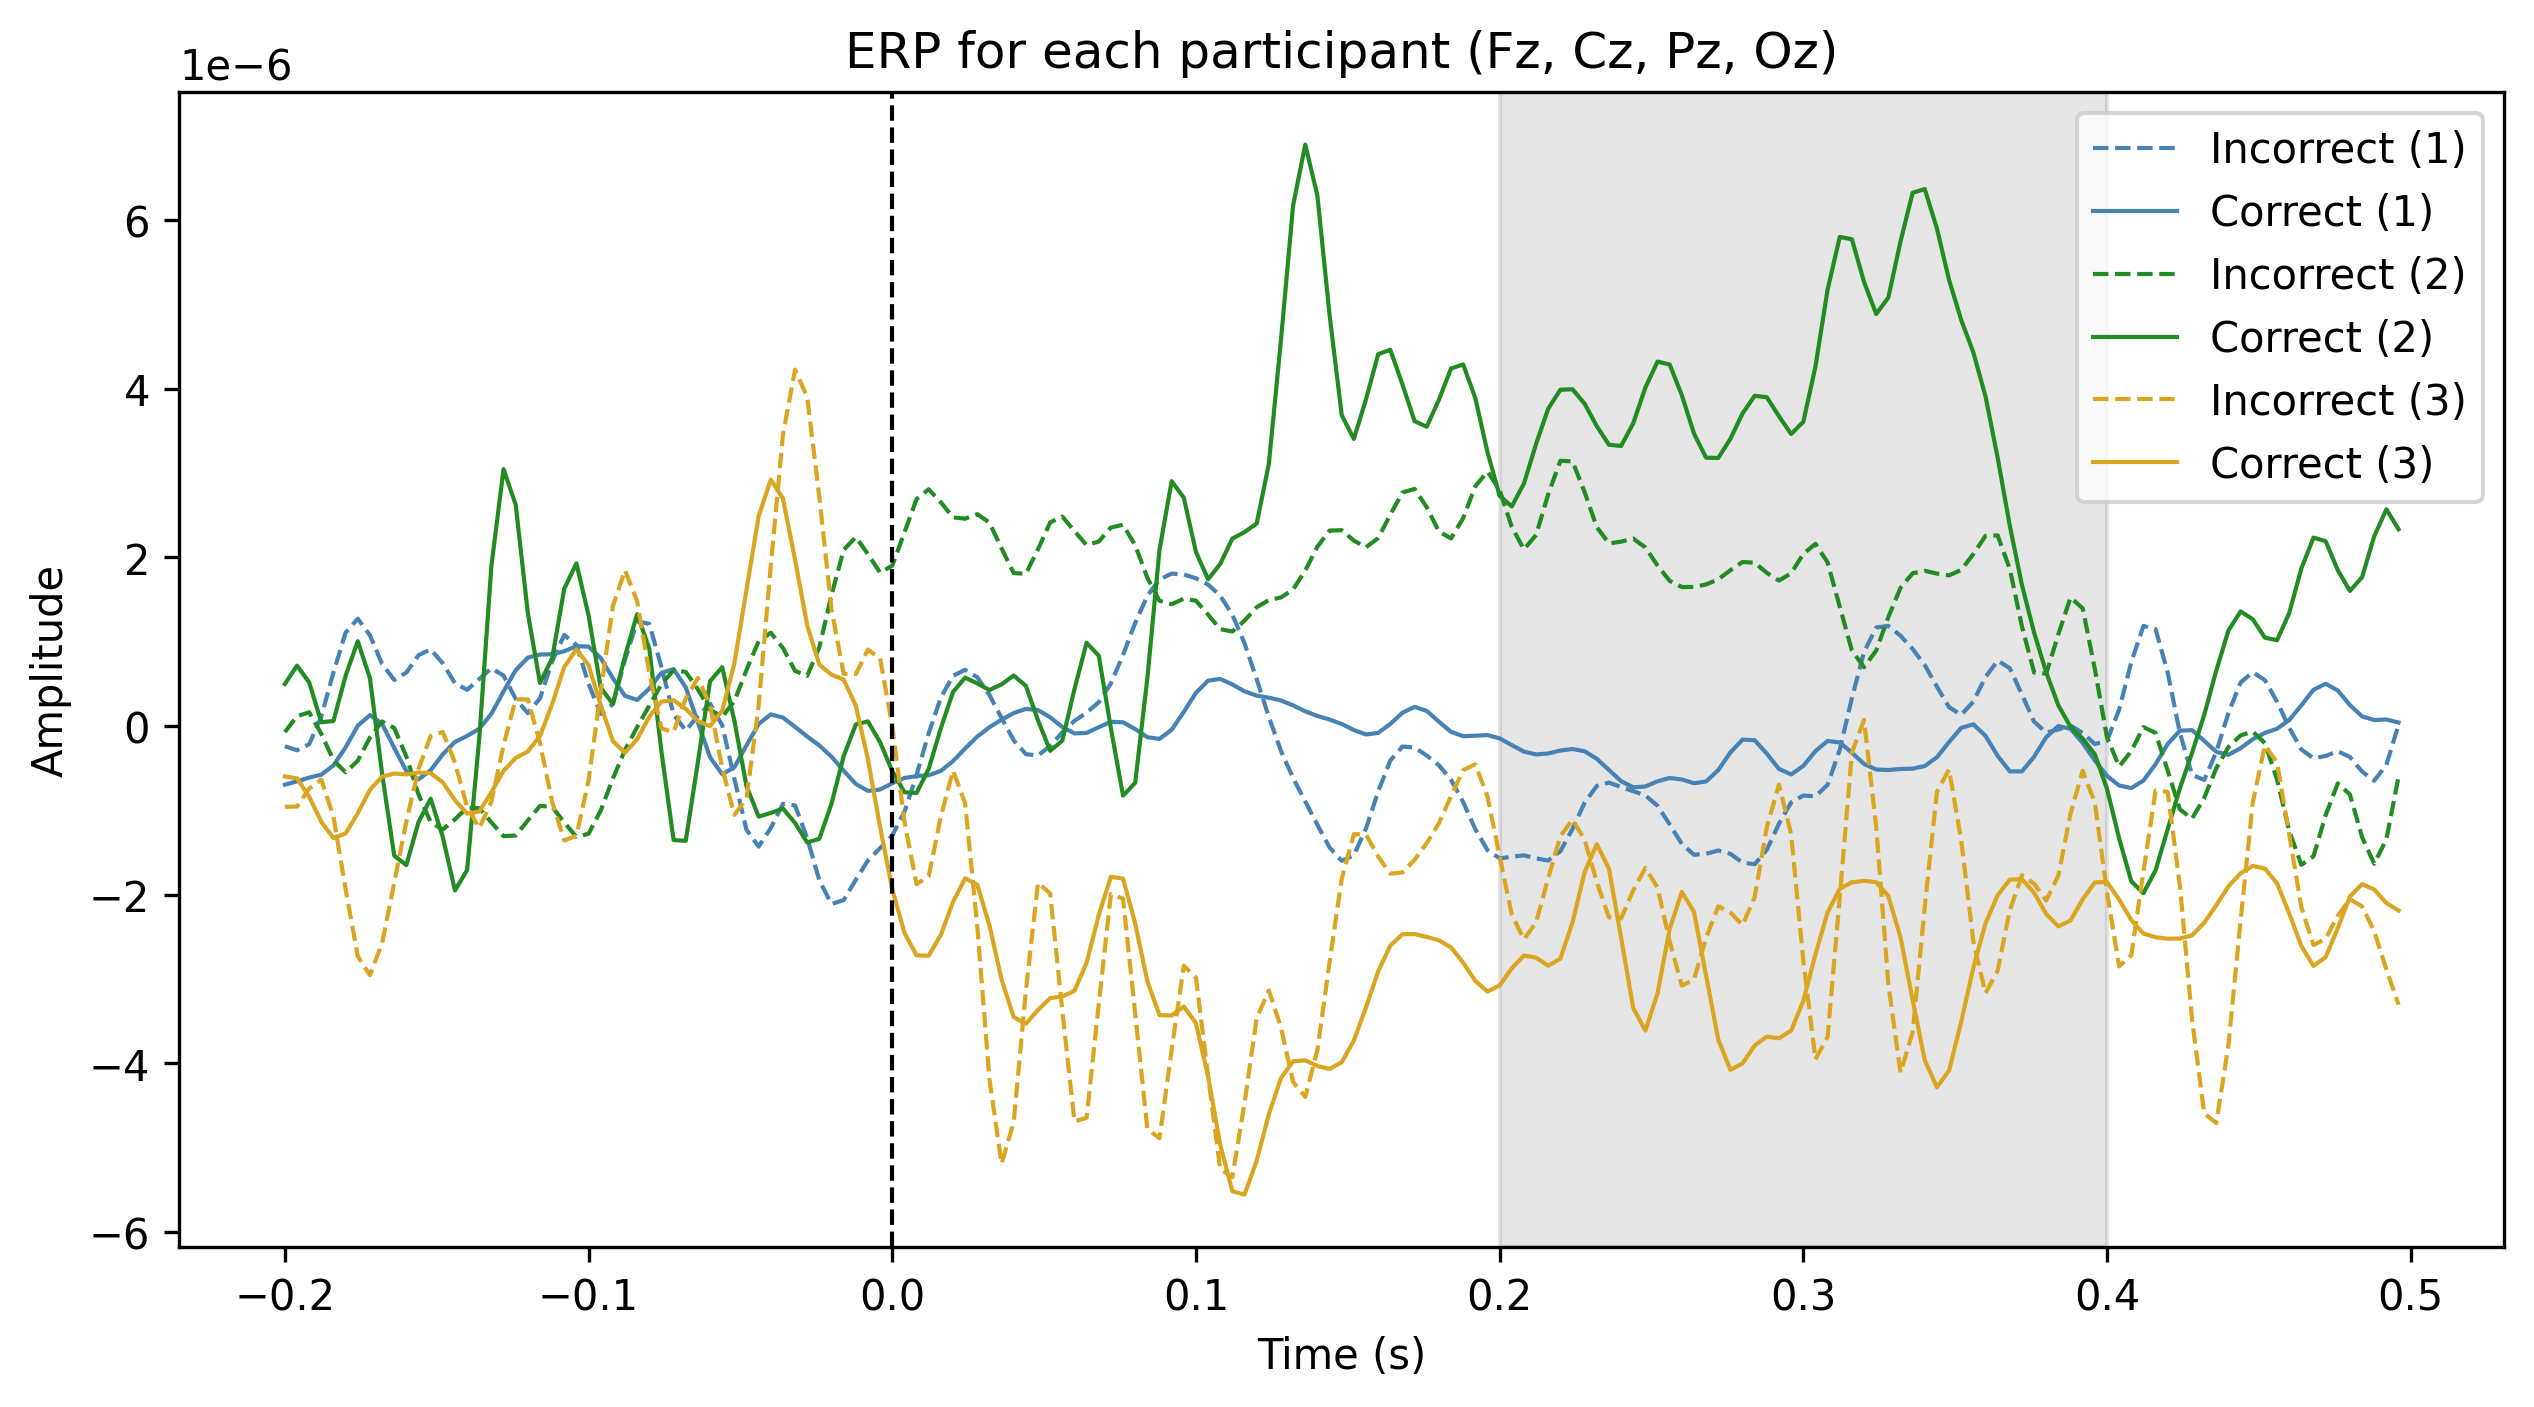

In [14]:
# plotting averaged timecourses for each participant
colours = ["steelblue", "forestgreen", "goldenrod"]

times = all_epochs[0].times

fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

for participant in range(3):
    # plot the time courses for each participant
    ax.plot(times, incorrect[participant, :], label=f"Incorrect ({participant+1})", linestyle="--", color=colours[participant], linewidth = 1)
    ax.plot(times, correct[participant, :], label=f"Correct ({participant+1})", linestyle="-", color=colours[participant], linewidth = 1)

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP for each participant (Fz, Cz, Pz, Oz)")
ax.legend()

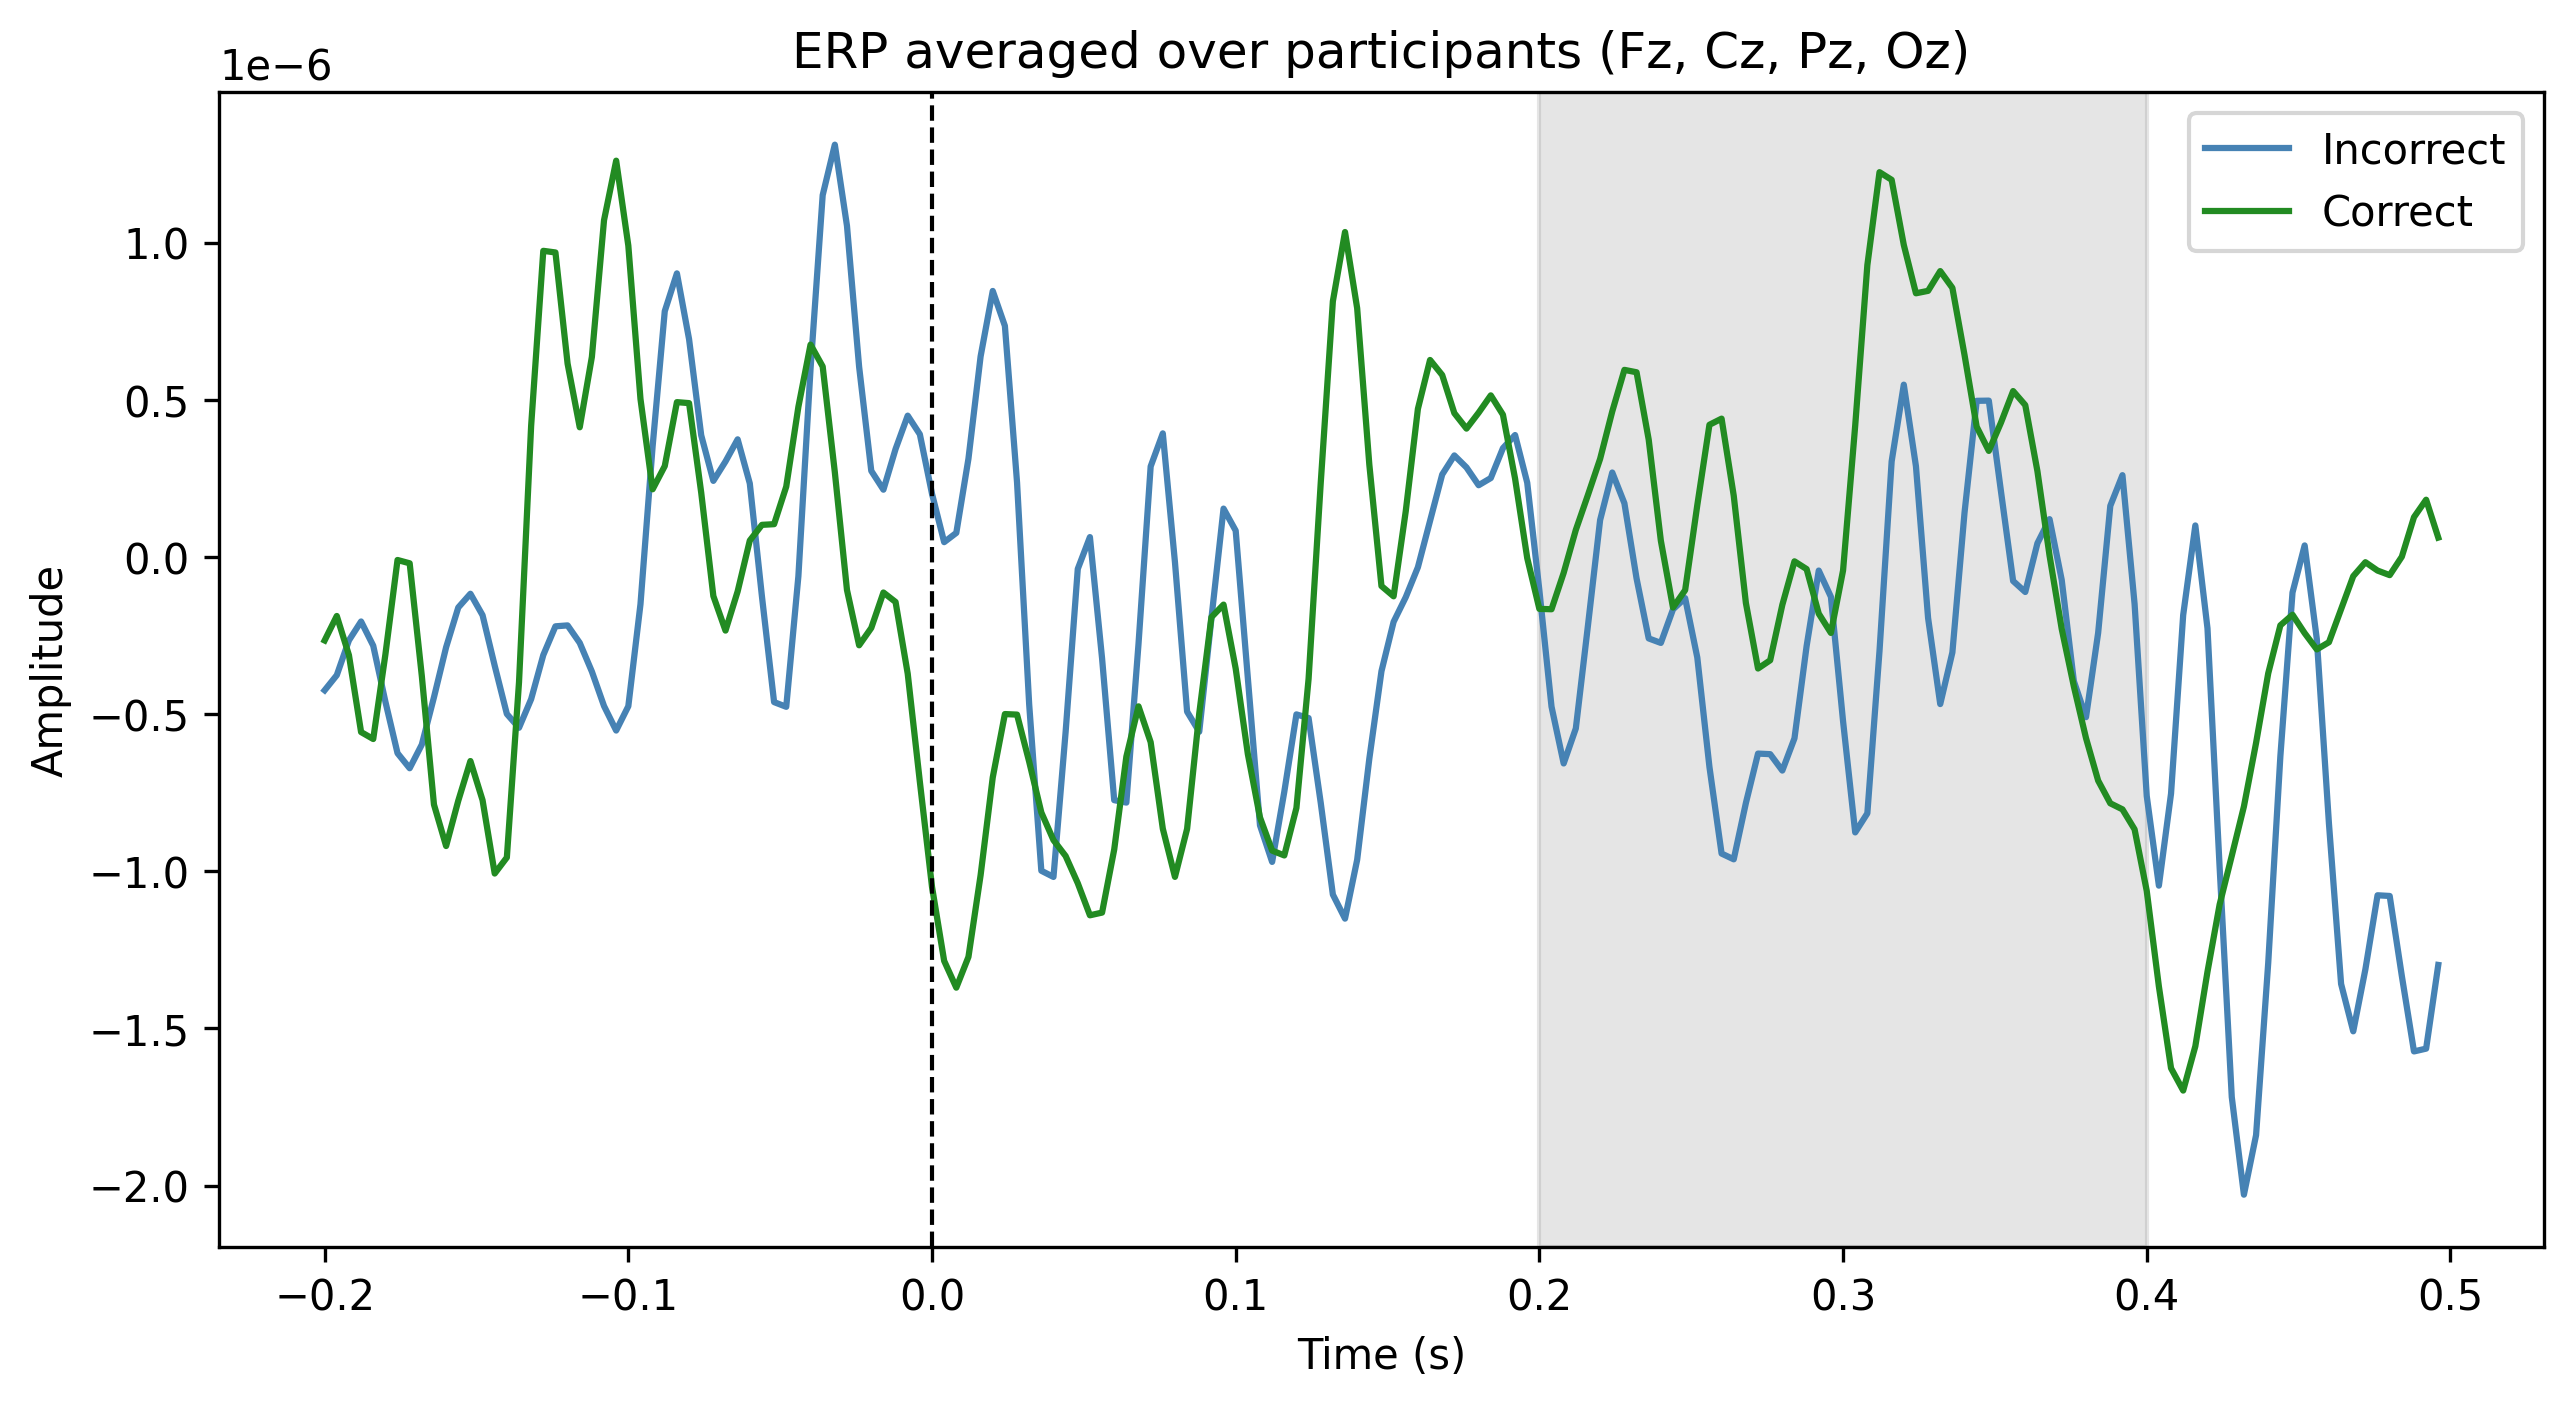

In [15]:
# averaging over participants
fig, ax = plt.subplots(1, figsize=(10, 5), dpi=300)

# plot the time window
ax.axvspan(tmin, tmax, color="grey", alpha=0.2)

ax.plot(times, incorrect.mean(axis=0), label="Incorrect", linestyle="-", color=colours[0])
ax.plot(times, correct.mean(axis=0), label="Correct", linestyle="-", color=colours[1])

# vertical line at 0
ax.axvline(x=0, color="black", linestyle="--", linewidth=1)

ax.set(xlabel="Time (s)", ylabel="Amplitude", title="ERP averaged over participants (Fz, Cz, Pz, Oz)")
ax.legend()